<a href="https://colab.research.google.com/github/TravisSHEN/data_driven_tasks/blob/master/flu_shot_prediction/FLu_Vaccination_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helper Functions

## Plot ROC Curve

In [185]:
# Define a function to plot roc curve
def _plot_roc_curve(y_eval, y_pred, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_eval, y_pred)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {label_name}: AUC={roc_auc_score(y_eval, y_pred):.4f}')
    ax.legend(loc='lower right')

def plot_roc(y_eval, y_preds):
  # Plot roc curve
  fig, ax = plt.subplots(1, 2, figsize=(12, 6))

  _plot_roc_curve(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'], 'H1N1 Vaccine', ax=ax[0])

  _plot_roc_curve(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine'], 'Seasonal Vaccine', ax=ax[1])

  fig.tight_layout()


# Load data

In [143]:
# Load data
from pathlib import Path

import numpy as np
import pandas as pd

In [144]:
DATA_PATH = Path.cwd() / 'flu_shot_data'
DATA_PATH.exists()

True

In [145]:
features_df = pd.read_csv(DATA_PATH / 'Training_Features.csv')
labels_df = pd.read_csv(DATA_PATH / 'Training_Labels.csv')

In [146]:
# Check features and labels shape
features_df.shape, labels_df.shape

((26707, 36), (26707, 3))

In [147]:
# Check few lines of data
features_df.head(), labels_df.head()

(   respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
 0              0           1.0             0.0                        0.0   
 1              1           3.0             2.0                        0.0   
 2              2           1.0             1.0                        0.0   
 3              3           1.0             1.0                        0.0   
 4              4           2.0             1.0                        0.0   
 
    behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
 0                   0.0                   0.0                    0.0   
 1                   1.0                   0.0                    1.0   
 2                   1.0                   0.0                    0.0   
 3                   1.0                   0.0                    1.0   
 4                   1.0                   0.0                    1.0   
 
    behavioral_large_gatherings  behavioral_outside_home  \
 0                          0.

In [12]:
# Check types of dataset
features_df.dtypes, '--------------------------', labels_df.dtypes

(respondent_id                    int64
 h1n1_concern                   float64
 h1n1_knowledge                 float64
 behavioral_antiviral_meds      float64
 behavioral_avoidance           float64
 behavioral_face_mask           float64
 behavioral_wash_hands          float64
 behavioral_large_gatherings    float64
 behavioral_outside_home        float64
 behavioral_touch_face          float64
 doctor_recc_h1n1               float64
 doctor_recc_seasonal           float64
 chronic_med_condition          float64
 child_under_6_months           float64
 health_worker                  float64
 health_insurance               float64
 opinion_h1n1_vacc_effective    float64
 opinion_h1n1_risk              float64
 opinion_h1n1_sick_from_vacc    float64
 opinion_seas_vacc_effective    float64
 opinion_seas_risk              float64
 opinion_seas_sick_from_vacc    float64
 age_group                       object
 education                       object
 race                            object


In [11]:
# Check if rows from features and labels match
np.testing.assert_array_equal(features_df['respondent_id'], labels_df['respondent_id'])

print(features_df.index, labels_df.index)

features_df.index.equals(labels_df.index)

RangeIndex(start=0, stop=26707, step=1) RangeIndex(start=0, stop=26707, step=1)


True

# Perform EDA over dataset

In [ ]:
%matplotlib inline
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


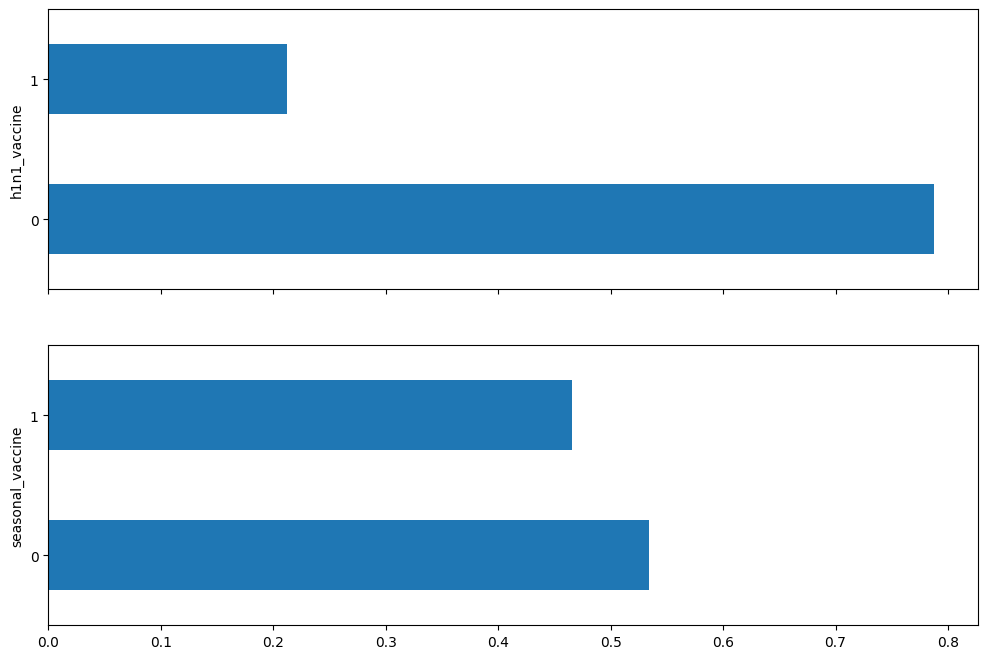

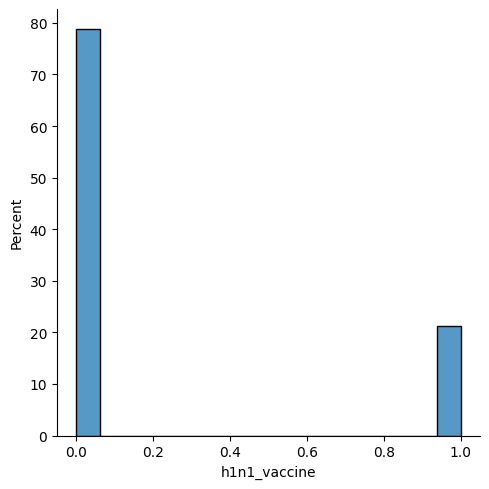

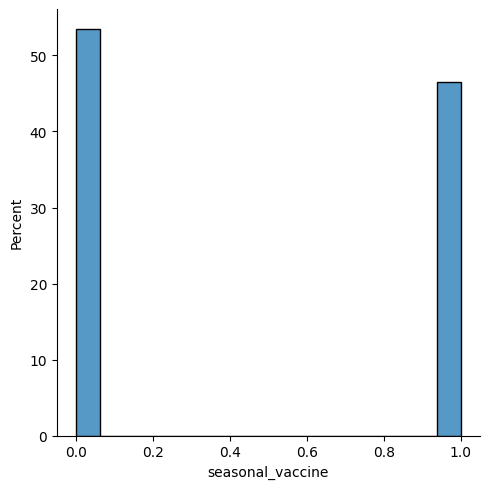

In [33]:
# Check distribution of the target variables

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Number of objects
n_obs = labels_df.shape[0]

# Plot percentages of who took h1n1_vaccine or seasonal_vaccine by bar chart
labels_df.h1n1_vaccine.value_counts(normalize=True).plot(kind='barh', ax=ax[0])
labels_df.seasonal_vaccine.value_counts(normalize=True).plot(kind='barh', ax=ax[1])

sns.displot(data=labels_df, x='h1n1_vaccine', ax=ax[0], stat='percent', multiple='stack')
sns.displot(data=labels_df, x='seasonal_vaccine', ax=ax[1], stat='percent', multiple='stack')


In [35]:
# Check independency between two variable
pd.crosstab(labels_df.h1n1_vaccine, labels_df.seasonal_vaccine,
            normalize='index', margins=True)

seasonal_vaccine,0,1
h1n1_vaccine,,
0,0.632102,0.367898
1,0.172189,0.827811
All,0.534392,0.465608


In [37]:
labels_df[['h1n1_vaccine', 'seasonal_vaccine']].corr()

,h1n1_vaccine,seasonal_vaccine
h1n1_vaccine,1.000000,0.377143
seasonal_vaccine,0.377143,1.000000


# Extract Features

In [148]:
from os import supports_effective_ids
# Combine features and labels into a single dataset

joined_df = pd.merge(features_df, labels_df, on='respondent_id')
# joined_df = features_df.join(labels_df, on='respondent_id', how='left', lsuffix='_features', rsuffix='_labels' )
joined_df.shape, joined_df.head()

((26707, 38),
    respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
 0              0           1.0             0.0                        0.0   
 1              1           3.0             2.0                        0.0   
 2              2           1.0             1.0                        0.0   
 3              3           1.0             1.0                        0.0   
 4              4           2.0             1.0                        0.0   
 
    behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
 0                   0.0                   0.0                    0.0   
 1                   1.0                   0.0                    1.0   
 2                   1.0                   0.0                    0.0   
 3                   1.0                   0.0                    1.0   
 4                   1.0                   0.0                    1.0   
 
    behavioral_large_gatherings  behavioral_outside_home  \
 0              

In [13]:
# Check how features correlated with the target variables
counts = (
    joined_df[['h1n1_concern', 'h1n1_vaccine']]
      .groupby(['h1n1_concern', 'h1n1_vaccine'])
      .size()
      .unstack('h1n1_vaccine')
)

counts

h1n1_vaccine,0,1
h1n1_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=counts)

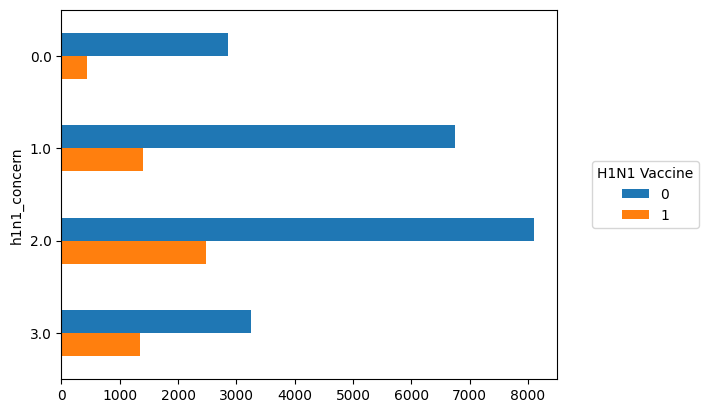

In [56]:
ax = counts.plot.barh()
ax.invert_yaxis()
ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), title='H1N1 Vaccine')

In [59]:
# Check in rates instead of count
h1n1_concern_counts = counts.sum(axis=1)
h1n1_concern_counts

,0
h1n1_concern,
0.0,3296
1.0,8153
2.0,10575
3.0,4591


In [60]:
props = counts.div(h1n1_concern_counts, axis=0)
props

h1n1_vaccine,0,1
h1n1_concern,,
0.0,0.864381,0.135619
1.0,0.828652,0.171348
2.0,0.766147,0.233853
3.0,0.707907,0.292093


In [71]:
# Plot
# ax = props.plot.barh()
# ax.invert_yaxis()
# ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), title='H1N1 Vaccine')

# plot horizontal interactive bar chart using plotly
import plotly.express as px
fig = px.bar(props, orientation='h', barmode='stack')
fig.show()

In [14]:
# Define a function to check through all other columns for the correlation to target variable
def vaccination_rate_plot(col, target, data, ax=None):

  counts = (
      data[[col, target]]
        .groupby([col, target])
        .size()
        .unstack(target)
  )

  group_counts = counts.sum(axis=1)
  props = counts.div(group_counts, axis=0)

  ax = props.plot.barh(ax=ax, legend=False, stacked=True)
  ax.invert_yaxis()
  # ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), title=target)


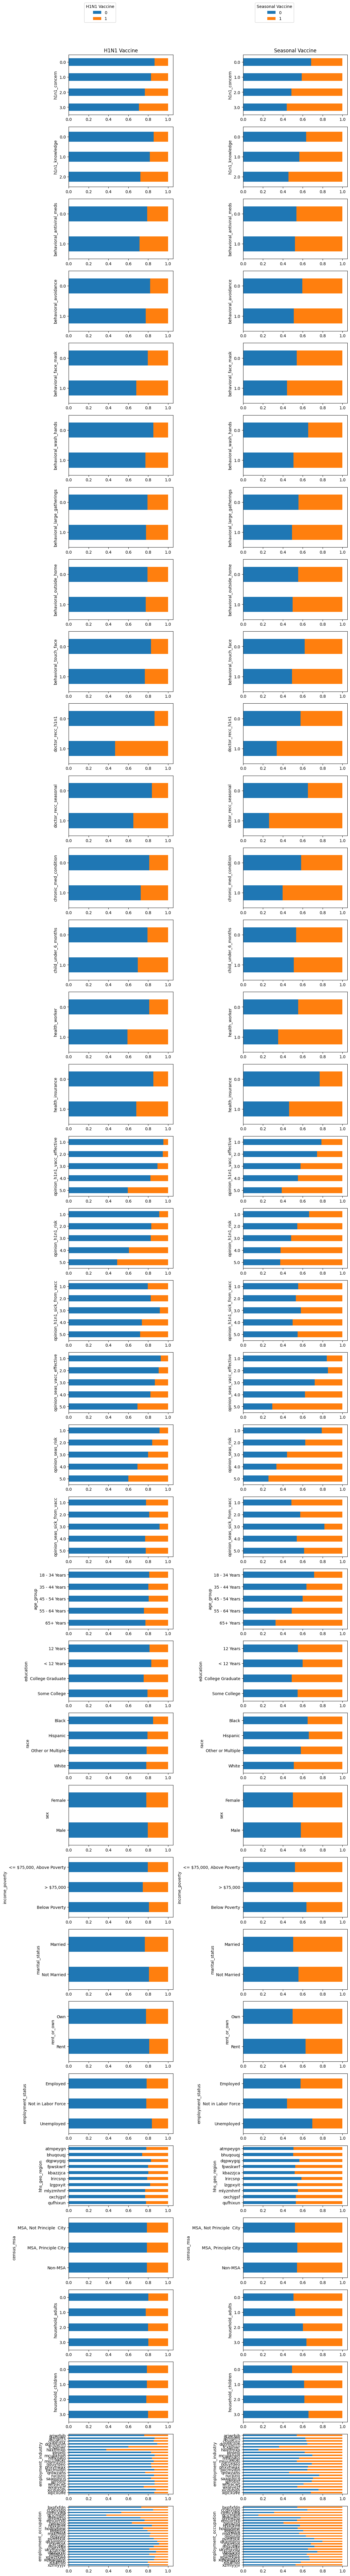

In [82]:
cols_to_plot = features_df.columns.drop(['respondent_id'])

# Plot using the vaccination_rate_plot function
fig, axes = plt.subplots(nrows=len(cols_to_plot), ncols=2, figsize=(12, len(cols_to_plot)*2.5))

for idx, col in enumerate(cols_to_plot):
  vaccination_rate_plot(col, 'h1n1_vaccine', joined_df, ax=axes[idx, 0])
  vaccination_rate_plot(col, 'seasonal_vaccine', joined_df, ax=axes[idx, 1])

axes[0, 0].set_title('H1N1 Vaccine')
axes[0, 1].set_title('Seasonal Vaccine')

axes[0, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='H1N1 Vaccine')
axes[0, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='Seasonal Vaccine')

fig.tight_layout()


# Build Models

In [149]:
# We now need to train a model to predict whether a respondent would take either one of vaccine

# Import related modules including
# 1. Scalar to handle outliers (normalize),
# 2. Imputer to handle missing values using mean
# 3. Logistic Regressor with multi output as we use single model to predict
# 4. split dataset
# 5. evaluation of model

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [150]:
numeric_cols = features_df.select_dtypes(include='number').columns
categorical_cols = features_df.select_dtypes(exclude='number').columns

numeric_cols, categorical_cols

(Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
        'behavioral_antiviral_meds', 'behavioral_avoidance',
        'behavioral_face_mask', 'behavioral_wash_hands',
        'behavioral_large_gatherings', 'behavioral_outside_home',
        'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
        'chronic_med_condition', 'child_under_6_months', 'health_worker',
        'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
        'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
        'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
        'household_children'],
       dtype='object'),
 Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
        'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
        'census_msa', 'employment_industry', 'employment_occupation'],
       dtype='object'))

In [151]:
# Use frequency encoder to encode categorical data
for col in categorical_cols:
  # print(f'{col}: {features_df[col].unique()}')
  freq_encoder = features_df[col].value_counts(normalize=True)
  features_df[col] = features_df[col].map(freq_encoder)
  print(f'{col}: {features_df[col].unique()}')

age_group: [0.20829745 0.14408208 0.19526716 0.25622496 0.19612836]
education: [0.09339921 0.22913043 0.39909091 0.27837945        nan]
race: [0.79462313 0.07930505 0.06035871 0.06571311]
sex: [0.59377691 0.40622309]
income_poverty: [0.12102854 0.57337103 0.30560043        nan]
marital_status: [0.46420807 0.53579193        nan]
rent_or_own: [0.75961889 0.24038111        nan]
employment_status: [0.40528442 0.53715734 0.05755823        nan]
hhs_geo_region: [0.10705059 0.10656382 0.11614932 0.07780732 0.07612236 0.16089415
 0.12225259 0.08398547 0.04216123 0.10701314]
census_msa: [0.26951736 0.43602801 0.29445464]
employment_industry: [       nan 0.07752112 0.03909696 0.13485834 0.02526725 0.06361666
 0.09202362 0.01607236 0.02137998 0.18449578 0.03939598 0.06511176
 0.06922329 0.00926964 0.0381999  0.00665321 0.01502579 0.04589968
 0.02429543 0.02055767 0.01106377 0.00097182]
employment_occupation: [       nan 0.08174058 0.13432047 0.09594319 0.02674322 0.03663972
 0.02576112 0.04139911 

In [152]:
# Transform the columns
numeric_preprocessing_steps = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_preprocessing_steps = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric_preprocessing_steps, numeric_cols),
    ('categorical', categorical_preprocessing_steps, categorical_cols)
])

# categorical_preprocessor.fit_transform(features_df)

In [155]:
from sklearn.preprocessing import OneHotEncoder

def transform_and_return_df(df, column_transformer, fit=True):
    """
    Apply ColumnTransformer to a DataFrame and return the result as a DataFrame
    with proper column names.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame to transform
    column_transformer : ColumnTransformer, optional
        Pre-configured ColumnTransformer object. If None, creates a basic one
    fit : bool, default=True
        Whether to fit_transform (True) or just transform (False)

    Returns:
    --------
    pandas.DataFrame
        Transformed data with appropriate column names
    """
    # Create a basic ColumnTransformer if none provided
    if column_transformer is None:
      raise ValueError("No column_transformer provided")

    # Transform the data
    if fit:
        transformed_data = column_transformer.fit_transform(df)
    else:
        transformed_data = column_transformer.transform(df)

    # Get feature names
    feature_names = []

    for name, transformer, features in column_transformer.transformers_:
        if name == 'drop' or transformer == 'drop':
            continue

        if transformer == 'passthrough':
            feature_names.extend(features)
        elif isinstance(transformer, OneHotEncoder):
            # Get categories for each categorical feature
            for i, feature in enumerate(features):
                cats = transformer.categories_[i]
                # Drop first category if drop='first'
                if transformer.drop == 'first':
                    cats = cats[1:]
                feature_names.extend([f"{feature}_{cat}" for cat in cats])
        else:
            feature_names.extend(features)

    # Return as DataFrame
    return pd.DataFrame(
        transformed_data,
        columns=feature_names,
        index=df.index
    )


## Prepare training and evaluation dataset

In [156]:
# Transform training and evaluation datasets
transformed_features_df = transform_and_return_df(features_df, preprocessor)
transformed_features_df.shape, transformed_features_df[:10]

((26707, 36),
    respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
 0      -1.731986     -0.680609       -2.046928                  -0.226911   
 1      -1.731856      1.520279        1.195647                  -0.226911   
 2      -1.731727     -0.680609       -0.425641                  -0.226911   
 3      -1.731597     -0.680609       -0.425641                  -0.226911   
 4      -1.731467      0.419835       -0.425641                  -0.226911   
 5      -1.731337      1.520279       -0.425641                  -0.226911   
 6      -1.731208     -1.781053       -2.046928                  -0.226911   
 7      -1.731078     -0.680609       -2.046928                  -0.226911   
 8      -1.730948     -1.781053        1.195647                  -0.226911   
 9      -1.730819      0.419835       -0.425641                  -0.226911   
 
    behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
 0             -1.632555             -0.272298       

In [169]:
# Generate training and evaluation dataset
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.3,
    shuffle=True,
    random_state=42
)

X_train.shape, X_eval.shape, y_train.shape, y_eval.shape

X_train.head(), X_eval.head(), y_train.head(), y_eval.head()

# type(X_train), type(X_eval), type(y_train), type(y_eval)

(       respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
 5303            5303           2.0             2.0                        0.0   
 2703            2703           2.0             1.0                        0.0   
 6586            6586           3.0             1.0                        0.0   
 22563          22563           1.0             2.0                        0.0   
 2338            2338           0.0             2.0                        0.0   
 
        behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
 5303                    0.0                   0.0                    1.0   
 2703                    1.0                   0.0                    1.0   
 6586                    1.0                   0.0                    1.0   
 22563                   0.0                   0.0                    0.0   
 2338                    1.0                   0.0                    1.0   
 
        behavioral_large_gatherings  behav

## Train with LogisticRegression Model

In [166]:
# Define estimator
estimators = MultiOutputClassifier(
    estimator=LogisticRegression(penalty='l2', C=1, max_iter=100)
)

estimators

MultiOutputClassifier(estimator=LogisticRegression(C=1))

In [167]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('estimators', estimators)
])

full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outsid...
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                ('estimators',
                 MultiOutputClassifier(estimator=LogisticRegression(C=1)))])

In [168]:
# Train the model
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outsid...
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                ('estimators',
                 MultiOutputClassifier(estimator=LogisticRegression(C=1)))])

### Evaluate Results

In [181]:
# Predict on evaluation set
y_pred = full_pipeline.predict(X_eval)
y_pred

array([[ 5909,     0,     0],
       [ 1898,     0,     0],
       [ 7289,     0,     1],
       ...,
       [12113,     0,     0],
       [  173,     0,     0],
       [18267,     0,     1]])

In [182]:
y_pred_proba = full_pipeline.predict_proba(X_eval)

# y_pred_proba[0].shape, y_pred_proba[1].shape

y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': y_pred_proba[0][:, 1],
        'seasonal_vaccine': y_pred_proba[1][:, 1]
    },
    index = y_eval.index
)

y_preds.head(), y_eval.head()

(       h1n1_vaccine  seasonal_vaccine
 15772      0.000009          0.114312
 9407       0.000021          0.095824
 16515      0.000018          0.072268
 23353      0.000011          0.131515
 10008      0.000022          0.131814,
        respondent_id  h1n1_vaccine  seasonal_vaccine
 15772          15772             0                 0
 9407            9407             0                 1
 16515          16515             0                 0
 23353          23353             0                 0
 10008          10008             0                 0)

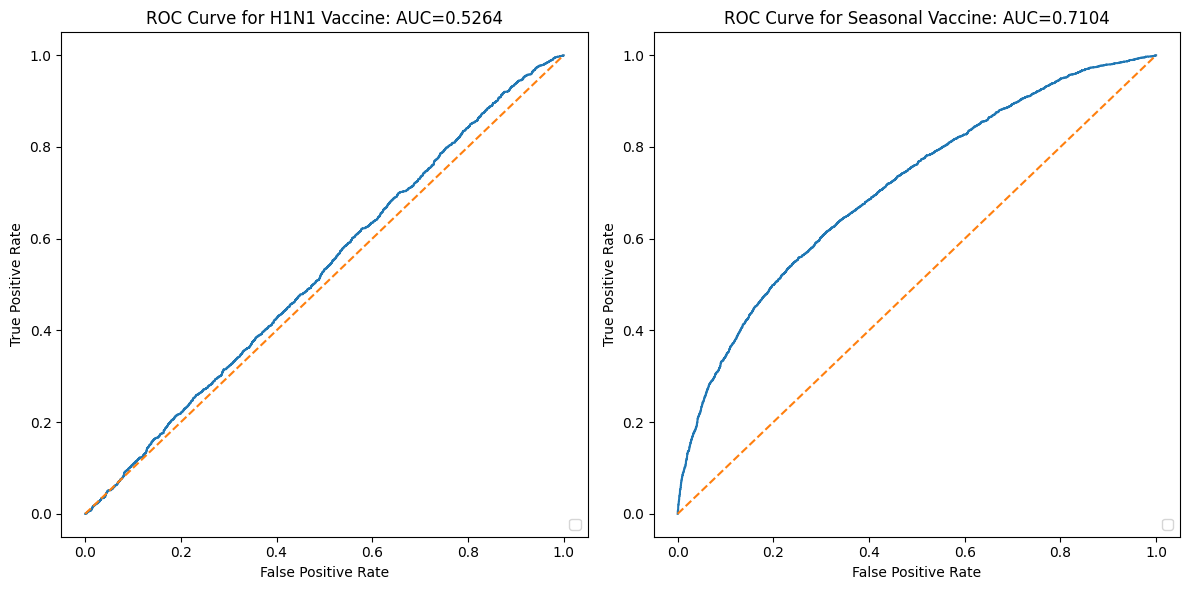

In [186]:
plot_roc(y_eval, y_preds)

In [ ]:
roc_auc_score(y_eval, y_preds)

## Train with XGBoost

In [201]:
# Define model with XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

h1n1_model = xgb.XGBClassifier(
    n_estimators=128,
    max_depth=8,
    learning_rate=0.01,
    tree_method='hist',
    # early_stopping_rounds=2,
)

h1n1_xgb_pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('h1n1_model', h1n1_model)
    ]
)

grid_h1n1_params = {
    'h1n1_model__max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'h1n1_model__learning_rate': [0.001, 0.01, 0.1, 0.20, 0.25, 0.30],
    "h1n1_model__gamma":[0, 0.25, 0.5, 0.75,1],
    'h1n1_model__n_estimators': [99, 100, 500, 1000],
    "h1n1_model__subsample":[0.9],
    "h1n1_model__colsample_bytree":[0.5],
    # "model__early_stopping_rounds": [10],
    # "model__random_state": [random_state],
}

grid_h1n1 = GridSearchCV(
    estimator=h1n1_xgb_pipeline,
    param_grid=grid_h1n1_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=3
)

seasonal_model = xgb.XGBClassifier(
    n_estimators=128,
    max_depth=8,
    learning_rate=0.01,
    tree_method='hist',
    # early_stopping_rounds=2,
)

seasonal_xgb_pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('seasonal_model', seasonal_model)
    ]
)

grid_seasonal_params = {
    'seasonal_model__max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'seasonal_model__learning_rate': [0.001, 0.01, 0.1, 0.20, 0.25, 0.30],
    "seasonal_model__gamma":[0, 0.25, 0.5, 0.75,1],
    'seasonal_model__n_estimators': [99, 100, 500, 1000],
    "seasonal_model__subsample":[0.9],
    "seasonal_model__colsample_bytree":[0.5],
    # "model__early_stopping_rounds": [10],
    # "model__random_state": [random_state],
}

grid_seasonal = GridSearchCV(
    estimator=seasonal_xgb_pipeline,
    param_grid=grid_seasonal_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=3
)

In [203]:
# Find best model of h1n1
grid_h1n1.fit(X_train, y_train['h1n1_vaccine'], **{'h1n1_model__eval_set': [(X_eval, y_eval['h1n1_vaccine'])]})

eval_auc = roc_auc_score(y_eval['h1n1_vaccine'], grid_h1n1.best_estimator_.predict_proba(X_eval)[:, 1])

eval_auc

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


ValueError: 
All the 4800 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4800 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1531, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2097, in update
    self._assign_dmatrix_features(dtrain)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 3040, in _assign_dmatrix_features
    self._validate_features(fn)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 3047, in _validate_features
    raise ValueError(
ValueError: training data did not have the following fields: respondent_id, h1n1_concern, h1n1_knowledge, behavioral_antiviral_meds, behavioral_avoidance, behavioral_face_mask, behavioral_wash_hands, behavioral_large_gatherings, behavioral_outside_home, behavioral_touch_face, doctor_recc_h1n1, doctor_recc_seasonal, chronic_med_condition, child_under_6_months, health_worker, health_insurance, opinion_h1n1_vacc_effective, opinion_h1n1_risk, opinion_h1n1_sick_from_vacc, opinion_seas_vacc_effective, opinion_seas_risk, opinion_seas_sick_from_vacc, age_group, education, race, sex, income_poverty, marital_status, rent_or_own, employment_status, hhs_geo_region, census_msa, household_adults, household_children, employment_industry, employment_occupation


In [175]:
# Train h1n1 model
h1n1_xgb_pipeline.fit(
    X_train, y_train['h1n1_vaccine'],
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outsid...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=128, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
# Find best model for seasonal
grid_seasonal.fit(X_train, y_train['seasonal_vaccine'], **{'seasonal_model__eval_set': [(X_eval, y_eval['seasonal_vaccine'])]})

eval_auc = roc_auc_score(y_eval['seasonal_vaccine'], grid_seasonal.best_estimator_.predict_proba(X_eval)[:, 1])

eval_auc

In [177]:
# Train seasonal model
seasonal_xgb_pipeline.fit(
    X_train, y_train['seasonal_vaccine'],
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outsid...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=128, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

### Evaluate Results

In [194]:
h1n1_y_pred_proba = h1n1_xgb_pipeline.predict(X_eval)
h1n1_y_pred_proba

array([0, 0, 0, ..., 0, 0, 0])

In [195]:
seasonal_y_pred_proba = seasonal_xgb_pipeline.predict(X_eval)
seasonal_y_pred_proba

array([0, 0, 1, ..., 0, 0, 1])

In [197]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine':  h1n1_y_pred_proba,
        'seasonal_vaccine': seasonal_y_pred_proba
    },
    index = y_eval.index
)

y_preds.head(), y_eval.head()

(       h1n1_vaccine  seasonal_vaccine
 15772             0                 0
 9407              0                 0
 16515             0                 1
 23353             0                 0
 10008             0                 0,
        respondent_id  h1n1_vaccine  seasonal_vaccine
 15772          15772             0                 0
 9407            9407             0                 1
 16515          16515             0                 0
 23353          23353             0                 0
 10008          10008             0                 0)

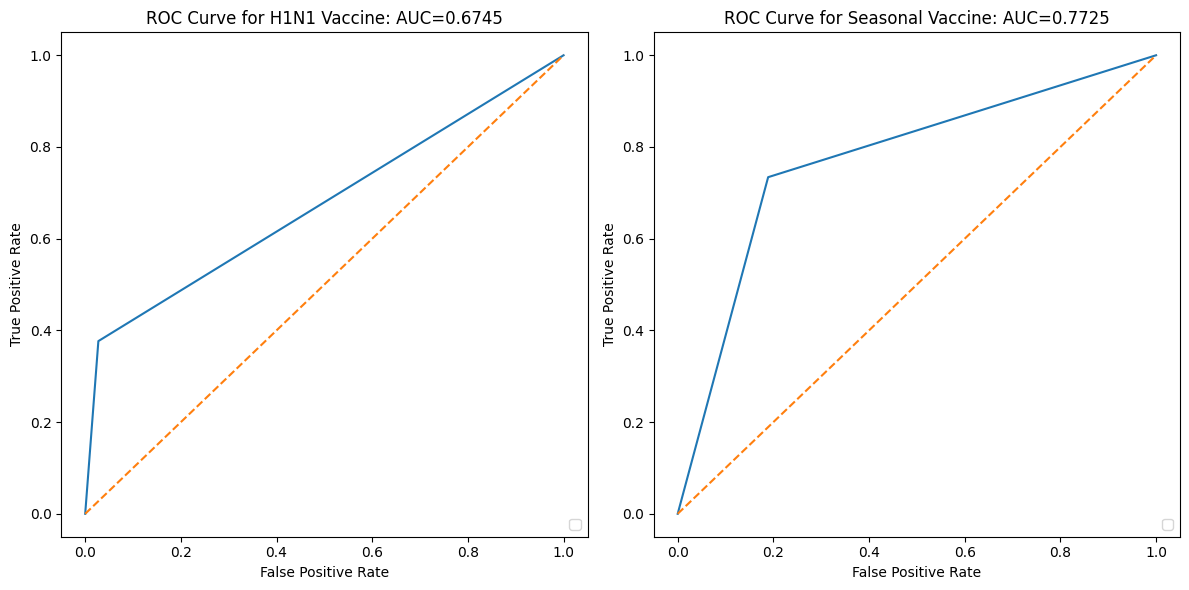

In [198]:
plot_roc(y_eval, y_preds)

# Train for test data set

In [104]:
# Retrain the model on whole dataset
full_pipeline.fit(features_df, labels_df)

# Generate predictions for test data set

In [103]:
test_features_df = pd.read_csv(DATA_PATH / 'Test_Features.csv')
test_features_df.shape

(26708, 36)

In [ ]:
# Predict
test_probas = full_pipeline.predict_proba(test_features_df)
test_probas

In [ ]:
# Read submission format file
submission_df = pd.read_csv(DATA_PATH / 'Submission_Format.csv', index_col='respondent_id')
submission_df.shape

In [ ]:
np.testing.assert_array_equal(test_features_df.index, submission_df.index)

submission_df['h1n1_vaccine'] = test_probas[0][:, 1]
submission_df['seasonal_vaccine'] = test_probas[1][:, 1]

submission_df.head()

In [ ]:
# Write into submission file
submission_df.to_csv('submission.csv', index=True)

In [ ]:
# Check the output
!head submission.csv